In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta
from math import comb
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



# Problem 1

In [2]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    #use binomial distribution to get n tosses of coin which gives heads with prob p 
    bin_sample = np.random.binomial(n, p)
    
    #for the plotting:
    x = np.linspace(0, 1, 1000)  #have 0, 1 because working with probability (which can only be in range of 0 to 1
    
    #now find equation 1.1: the prior will cancel out since it will be uniform distrib here, so will be a 
    #constant so will cancel out in the numerator and denominator. So just need to find f(x|theta) here
    #can use binom.pmf to get the pmf of the binomial distrib
    
    numerator = np.array([binom.pmf(bin_sample, n, i) for i in x])  
    
    #in binom.pmf: 1st thing is our samples, 2nd parameters is number of samples have (n), 3rd parameter is the 
    #prob part (goes with p), but want to loop over our range of prob have (why have the list comprehension with x)
    #need to put it in an array so that can plot it
    
    denominator = np.sum(numerator)  #says dont have to actually find the integral: just need to find the finite
                                     #approx of the stuff in numerator for the denom: and an integral is like a 
                                     #sum so to approx the integral: just sum the stuff want the integral of 
            
    posterior = numerator / denominator   #actually get the posterior
    
    #plot the posterior:
    plt.plot(x, posterior)
    plt.xlabel("fairness p of coin")
    plt.ylabel("size of sample n")
    plt.title("Posterior Distribution for p =.2, n = 100")
    
    plt.show()

    #get the MAP: it is the argmax of the posterior
    #the MAP: want the x value (not the y). So, want x[index of the thing that maximizies]. argmax of the posterior
    #will get this index
    MAP = x[np.argmax(posterior)] 
    
    return MAP

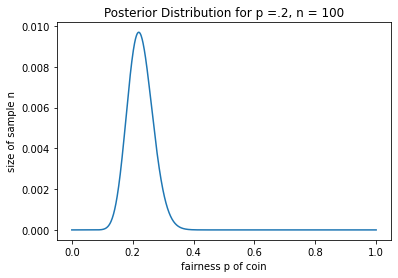

0.22022022022022023

In [3]:
bernoulli_sampling(0.2, 100)

# Problem 2

In [4]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    #use binomial distribution to get n tosses of coin. Simulate n coin flips
    bin_sample = np.random.binomial(n, p)
    
    #for the plotting:
    x = np.linspace(0, 1, 1000)  #have 0, 1 because working with probability (which can only be in range of 0 to 1
    
    #now calculate the posterior distribution: first get the numerator, denominator in it
    numerator = np.array([binom.pmf(bin_sample, n, x_i) * prior.pdf(x_i) for x_i in x])
    #P(x|t) is binomial distribution, so to get this prob: use binomial distrib pmf and then need to loop through
    #all of the x values in our domain. Given prior scipy distrib parameter
    
    denominator = np.sum(numerator)  #just like problem 1: can approximate integral that have in denominator
                                     #with Bayesian stats stuff by taking a sum 
    
    posterior = numerator / denominator  #now get the actual posterior
    
    #now plot the posterior distribution
    plt.plot(x, posterior)
    plt.xlabel("fairness p of coin")
    plt.ylabel("size of sample n")
    plt.title("Posterior Distribution")
    
    plt.show()
    
    #also want to get the MAP and return the MAP
    MAP = x[np.argmax(posterior)] 
    
    print(MAP) 

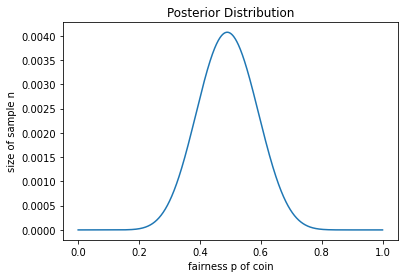

0.4894894894894895


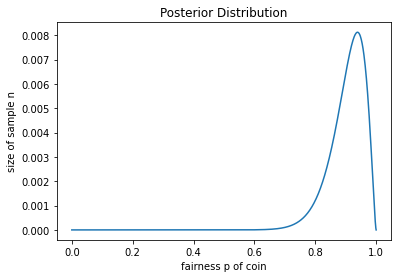

0.938938938938939


In [5]:
#told in problem that want to estimate the bias if have 90% of getting heads, 40% of getting heads
non_uniform_prior(0.4, 20, beta(5, 1.5))
non_uniform_prior(0.9, 20, beta(5, 1.5))

# Problem 3

In [6]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. 
    """
    #make all of the weather states correspond to a # and then once have added all of the #s: change them to the
    #corresponding weather they are
    
    current_state = 0          #we want to initialize being sunny as 0 since want the 1st day to be sunny 
    weather = [current_state]  #list of the weather strings. Initialize it with the first weather state in it, so
                               #put current_state into it
    
    for i in range(days - 1):   #now loop through all of the days and add weather state to our list 
        current_state = np.random.choice([0, 1, 2], p = transition_matrix[current_state])  #get random choice from
                                #our weather matrix for which weather the next day has
                                #and that random choice will become the current_state for next time loop through
        weather.append(current_state)  
        
    #now change the number to be the corresponding weather state we defined it to be
    for i in range(len(weather)):
        if weather[i] == 0:
            weather[i] = "sun"
        elif weather[i] == 1:
            weather[i] = "rain"
        elif weather[i] == 2:
            weather[i] = "wind"
            
    return weather

In [7]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)

In [8]:
#want to test function with 10 days
weather_forecast(transition_matrix, 10)

['sun', 'sun', 'sun', 'sun', 'sun', 'rain', 'sun', 'rain', 'wind', 'wind']

# Problem 4

In [9]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Print a trace plot. Return the mean for the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    
    #set up PyMC3 model based off lab manual example:
    model = pm.Model()
    with model:
        p_val = pm.Beta('p_val', alpha = 1, beta = 1)      #p has prior Beta(1,1)
        y = pm.Bernoulli('y', p = p_val, observed = data)  #data distributed as Bernoulli(p)
        trace = pm.sample(n)  #want sample posterior n times
        
        #plot the trace
        az.plot_trace(trace)
        p_val = trace['p_val']
        mean = p_val.mean()   #get the mean of posterior
        
    return float(mean)

/tmp/ipykernel_5861/2261138282.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n)  #want sample posterior n times
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_val]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


0.18735867697210626

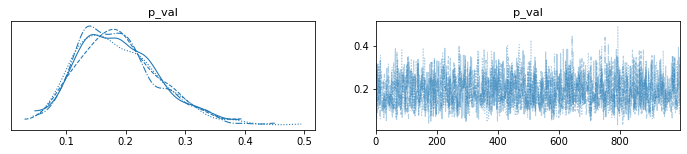

In [10]:
data = bernoulli.rvs(0.2, size=30)
posterior_sampling(data, n = 1000)

# Problem 5

In [11]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):

    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu,1/tau) where mu has a prior of Normal(m,s), and tau has
    a prior of Gamma(alpha,beta). Set up a PyMC3 model for this situation and sample 
    from the poterior n times. Print a trace plot for mu and tau. Return the mean 
    for the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    #create multivariate PyMC3 model, follow same process as problem 4
    model = pm.Model()
    with model:
        mu = pm.Normal('mu', m, s)  #mu is prior of Normal(m,s)
        tau = pm.Gamma('tau', alpha, beta)  #tau is prior of Gamma(alpha, beta)
        
        p = pm.Normal('p', mu, 1 / tau, observed = observed_heights)  #data distributed as Normal(mu, 1/tau)
        
        trace = pm.sample(n)        #sample from posterior n times
        
        #plot the traces
        az.plot_trace(trace)        
        mu = trace['mu']            #print trace plot for mu
        tau = trace['tau']          #print trace plot for tau
        mean = mu.mean()            #want return mean for posterior of mu
        
    return float(mean)

/tmp/ipykernel_5861/579869398.py:29: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n)        #sample from posterior n times
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


181.70482858091745

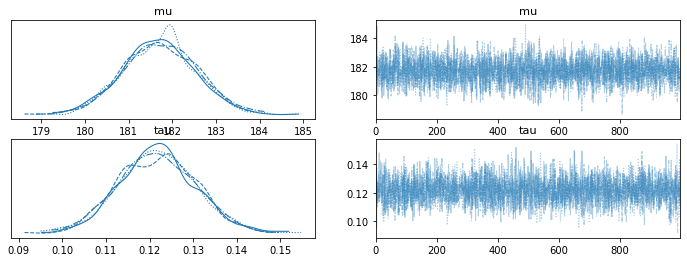

In [12]:
heights = np.random.normal(180,10,100)
height_model(heights, m = 180, s = 10, alpha = 2, beta = 10, n = 1000)